# Retrieving DSK data

DSKs are provided for many solar system bodies and we can also make our own from ICQ files of DTMs.
The NAIF SPICE program `mkdsk` can produce the DSK file, but needs an input file that specifies the input dataset and some other things. An example of the `mkdsk_input.txt` file is:
```
\begindata
 
   INPUT_SHAPE_FILE    = 'phobos_quad512q.tab'
   OUTPUT_DSK_FILE     = 'phobos512.bds'
   COMMENT_FILE        = ' '
   KERNELS_TO_LOAD     = ( 'naif0012.tls' )
   SURFACE_NAME        = 'Gaskell Phobos Q=512'
   CENTER_NAME         = 'PHOBOS'
   REF_FRAME_NAME      = 'IAU_PHOBOS'
   START_TIME          = '1950-JAN-1/00:00:00'
   STOP_TIME           = '2050-JAN-1/00:00:00'
   DATA_CLASS          = 1
   INPUT_DATA_UNITS    = ( 'ANGLES    = DEGREES'
                           'DISTANCES = KILOMETERS' )
   COORDINATE_SYSTEM   = 'LATITUDINAL'
   MINIMUM_LATITUDE    =  -90.0
   MAXIMUM_LATITUDE    =   90.0
   MINIMUM_LONGITUDE   = -180.0
   MAXIMUM_LONGITUDE   =  180.0
   DATA_TYPE           = 2
   PLATE_TYPE          = 2
 
   NAIF_SURFACE_NAME   += 'Gaskell Phobos Q=512'
   NAIF_SURFACE_CODE   += 1
   NAIF_SURFACE_BODY   += 401
 
\begintext
```

i.e. this converts phobos_quad512q.tab to phobos512.bds, which is a kernel that can be furnished below.

In [16]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.animation import FFMpegWriter
import spiceypy as cspice

rootfolder = '/Users/shane/Desktop/PTYS_551_code/PTYS551_2024/'

cspice.furnsh(rootfolder+'Class_Demos/DSK/phobos512.bds')

## Convert the DSK data into arrays of 3D points
Here we set up 2D latitude and longitude arrays, then convert them to 1D and append them together. These lat/lons are supplied to `cspice.latsrf` to extract the 3D position in the body frame of every surface point. The x,y,z coordinates of these points are reshaped into 2D arrays that have the same format as the original lat/lon arrays i.e they're global maps.
A color scale is devised by stretching the `turbo` scale between the min and max radii. 

In [17]:
lat = np.zeros([360,181]) 
lon = np.zeros([360,181]) 
for k in range(0,360):
    lat[k,:] = np.arange(-90,91,1) * np.pi/180.0
for k in range(0,181):
    lon[:,k] = np.arange(0,360,1) * np.pi/180.0
ll = np.ascontiguousarray(np.transpose(np.stack((lon.ravel(),lat.ravel()))))

srfpts = cspice.latsrf('DSK/UNPRIORITIZED','Phobos',0.0,'IAU_PHOBOS',ll)    # Retrieve Surface coordinates

rr     = np.sqrt(np.sum(srfpts**2,axis=1)).reshape(360,181)   # create 2D array of distances from center of Phobos
norm   = plt.Normalize(rr.min(), rr.max())
colors = plt.cm.turbo(norm(rr))

x = srfpts[:,0].reshape(360,181)  # create 2D arrays of x coordinates
y = srfpts[:,1].reshape(360,181)  # create 2D arrays of y coordinates
z = srfpts[:,2].reshape(360,181)  # create 2D arrays of z coordinates

Display the 3D data in a nice perspective view. Change the elev and azim keywords in `ax.view_init` to change the viewpoint.

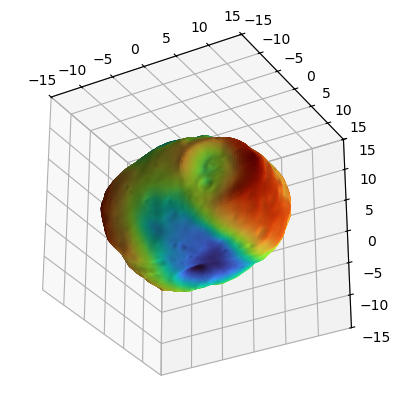

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surface = ax.plot_surface(x,y,z,facecolors=colors, rstride=1, cstride=1)

ax.view_init(elev=-30., azim=300)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
ax.set_zlim([-15,15])
ax.set_aspect('equal')
plt.show()

...or create a movie by spinning things around in the azimuth direction with a fixed elevation.

In [11]:
# Define the update function
def update(num):
    ax.view_init(elev=30., azim=num)
    return surface,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(0, 360, 1), blit=True)
ani.save('/Users/shane/Desktop/movie_phobos.mp4', writer='ffmpeg')

plt.show()